# Análise e Visualização da Camada Gold

Este notebook contém as funções de visualização e recomendação baseadas nos dados da camada Gold.

In [14]:
!pip install pandas matplotlib pyarrow fastparquet numpy plotly scikit-learn nbformat

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.io as pio
from sklearn.decomposition import TruncatedSVD
from scipy import sparse

# Configuração de diretórios
# Assume que o notebook está rodando em bigdata/notebooks
BASE_DIR = os.path.abspath("..")
SILVER_DIR = os.path.join(BASE_DIR, "dados", "silver")
GOLD_DIR = os.path.join(BASE_DIR, "dados", "gold")

print(f"Base Dir: {BASE_DIR}")
print(f"Silver Dir: {SILVER_DIR}")
print(f"Gold Dir: {GOLD_DIR}")

Base Dir: /Users/Jonathas/Desktop/college-code/big-data/bigdata
Silver Dir: /Users/Jonathas/Desktop/college-code/big-data/bigdata/dados/silver
Gold Dir: /Users/Jonathas/Desktop/college-code/big-data/bigdata/dados/gold


## Função de Recomendação

In [16]:
def recommend(user_id: int, n: int = 10) -> pd.DataFrame:
    scores = pd.read_parquet(f"{GOLD_DIR}/movies_scores.parquet")
    profiles = pd.read_parquet(f"{GOLD_DIR}/user_genre_profiles.parquet")
    ratings = pd.read_parquet(f"{SILVER_DIR}/ratings_clean.parquet")
    movies = pd.read_parquet(f"{SILVER_DIR}/movies_clean.parquet")

    # gênero favorito
    pref = profiles[profiles["userId"] == user_id]
    if pref.empty:
        print("Usuário sem histórico suficiente.")
        return pd.DataFrame()

    fav_genre = pref.sort_values("rating_mean", ascending=False).iloc[0]["genre"]
    print(f"Gênero favorito do usuário {user_id}: {fav_genre}")

    # filmes já avaliados
    rated_ids = set(ratings[ratings["userId"] == user_id]["movieId"].unique())

    # explode para filtrar por gênero
    df = movies.explode("genres_list", ignore_index=True)
    df["genre"] = df["genres_list"].apply(lambda d: d.get("name") if isinstance(d, dict) else None)
    df = df[df["genre"] == fav_genre]

    # ==== 🔥 MERGE CORRETO: pegar title do movies_clean ====
    df = df.merge(
        scores[["id", "weighted_rating"]],
        left_on="id",
        right_on="id",
        how="inner"
    )

    # remover avaliados
    df = df[~df["id"].isin(rated_ids)]

    # ordenar
    df = df.sort_values("weighted_rating", ascending=False)

    # selecionar colunas finais
    return df[["id", "title", "genre", "weighted_rating"]].head(n)

## Visualizações Gráficas

In [17]:
# 1) Gráfico — Distribuição do Weighted Rating
def plot_weighted_rating_distribution():
    df = pd.read_parquet(f"{GOLD_DIR}/movies_scores.parquet")

    plt.figure(figsize=(10, 6))
    df["weighted_rating"].hist(bins=40)
    plt.title("Distribuição do Weighted Rating")
    plt.xlabel("Weighted Rating")
    plt.ylabel("Frequência")
    plt.show()

In [18]:
# 2) Gráfico — Top 20 filmes por Weighted Rating
def plot_top20_movies():
    df = pd.read_parquet(f"{GOLD_DIR}/movies_scores.parquet")

    top20 = df.sort_values("weighted_rating", ascending=False).head(20)

    plt.figure(figsize=(10, 8))
    plt.barh(top20["title"], top20["weighted_rating"])
    plt.title("Top 20 Filmes por Weighted Rating")
    plt.xlabel("Weighted Rating")
    plt.ylabel("Filme")
    plt.gca().invert_yaxis()
    plt.show()

In [19]:
#Gráfico 3 — Relação entre orçamento e receita (scatter)

# na casa do milhao
def plot_budget_revenue_relation():
    movies = pd.read_parquet(f"{SILVER_DIR}/movies_clean.parquet")

    df = movies.dropna(subset=["budget", "revenue"])
    df = df[(df["budget"] > 0) & (df["revenue"] > 0)]  # evitar zeros

    plt.figure(figsize=(8,6))
    plt.scatter(df["budget"], df["revenue"], alpha=0.3)
    plt.title("Relação entre Orçamento (Budget) e Receita (Revenue)")
    plt.xlabel("Budget")
    plt.ylabel("Revenue")
    plt.show()


In [20]:
# Gráfico 4 — Distribuição de gêneros mais populares (por quantidade de filmes)

def plot_popular_genres():
    movies = pd.read_parquet(f"{SILVER_DIR}/movies_clean.parquet")

    df = movies.explode("genres_list", ignore_index=True)
    df["genre"] = df["genres_list"].apply(lambda d: d.get("name") if isinstance(d, dict) else None)
    genre_count = df["genre"].value_counts().head(20)

    plt.figure(figsize=(10,6))
    plt.bar(genre_count.index, genre_count.values)
    plt.title("Top 20 Gêneros com Mais Filmes")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Quantidade de Filmes")
    plt.show()


## Teste de Recomendação

In [21]:
def test_recommendation_example():
    print("\n=== Teste de Recomendação ===")

    # pegar um usuário que realmente existe no dataset
    profiles = pd.read_parquet(f"{GOLD_DIR}/user_genre_profiles.parquet")
    example_user = profiles["userId"].sample(1).iloc[0]

    print(f"Usuário de teste: {example_user}")

    recs = recommend(example_user, n=10)

    print("\nTop 10 recomendações:")
    print(recs[["title", "weighted_rating"]])

In [22]:
def plot_recommendation_score_distribution(user_id=1, n=20):
    recs = recommend(user_id, n)

    if recs.empty:
        print("Usuário sem recomendações suficientes.")
        return

    plt.figure(figsize=(10,5))
    plt.hist(recs["weighted_rating"], bins=10)
    plt.title(f"Distribuição do Weighted Rating das Recomendações (user {user_id})")
    plt.xlabel("Weighted Rating")
    plt.ylabel("Frequência")
    plt.show()


In [23]:
def compare_user_vs_public(user_id: int, max_filmes: int = 20):

    ratings = pd.read_parquet(f"{SILVER_DIR}/ratings_clean.parquet")
    movies = pd.read_parquet(f"{SILVER_DIR}/movies_clean.parquet")

    ratings["movieId"] = pd.to_numeric(ratings["movieId"], errors="coerce").astype("Int64")
    ratings["userId"]  = pd.to_numeric(ratings["userId"], errors="coerce").astype("Int64")
    movies["id"]       = pd.to_numeric(movies["id"], errors="coerce").astype("Int64")

    user = ratings[ratings["userId"] == user_id].copy()
    if user.empty:
        print(f"O usuário {user_id} não avaliou nenhum filme.")
        return

    public_mean = (
        ratings
        .groupby("movieId")["rating"]
        .mean()
        .reset_index()
        .rename(columns={"rating": "public_mean"})
    )

    df = user.merge(public_mean, on="movieId", how="left")

    df = df.merge(movies[["id", "title"]], left_on="movieId", right_on="id", how="left")

    df = df.sort_values(by="rating", ascending=False).head(max_filmes)

    fig = px.bar(
        df,
        y="title",
        x=["rating", "public_mean"],
        orientation="h",
        title=f"Comparação: Avaliação do Usuário {user_id} vs Média do Público",
        labels={"value": "Nota", "title": "Filme"},
        barmode="group",
        hover_data={"movieId": True, "title": False}
    )

    fig.update_yaxes(autorange="reversed")
    fig.show()


## Execução dos Gráficos e Testes

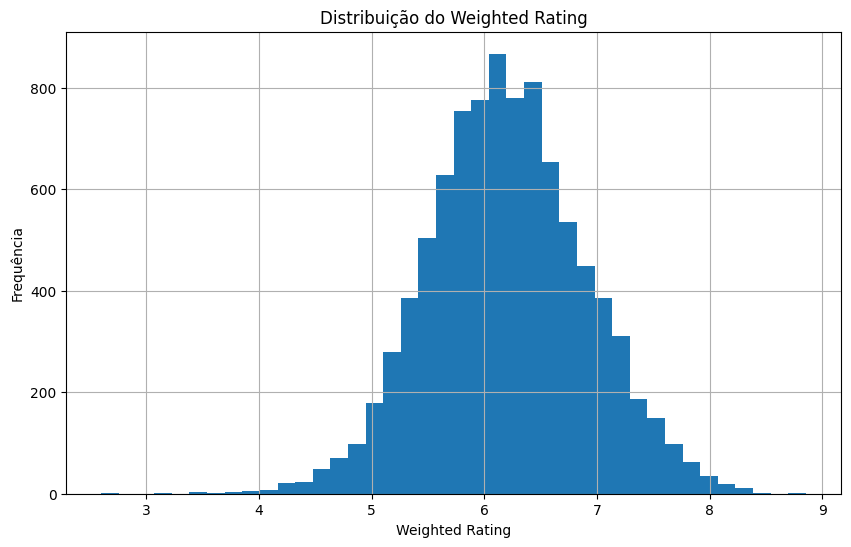

In [24]:
plot_weighted_rating_distribution()

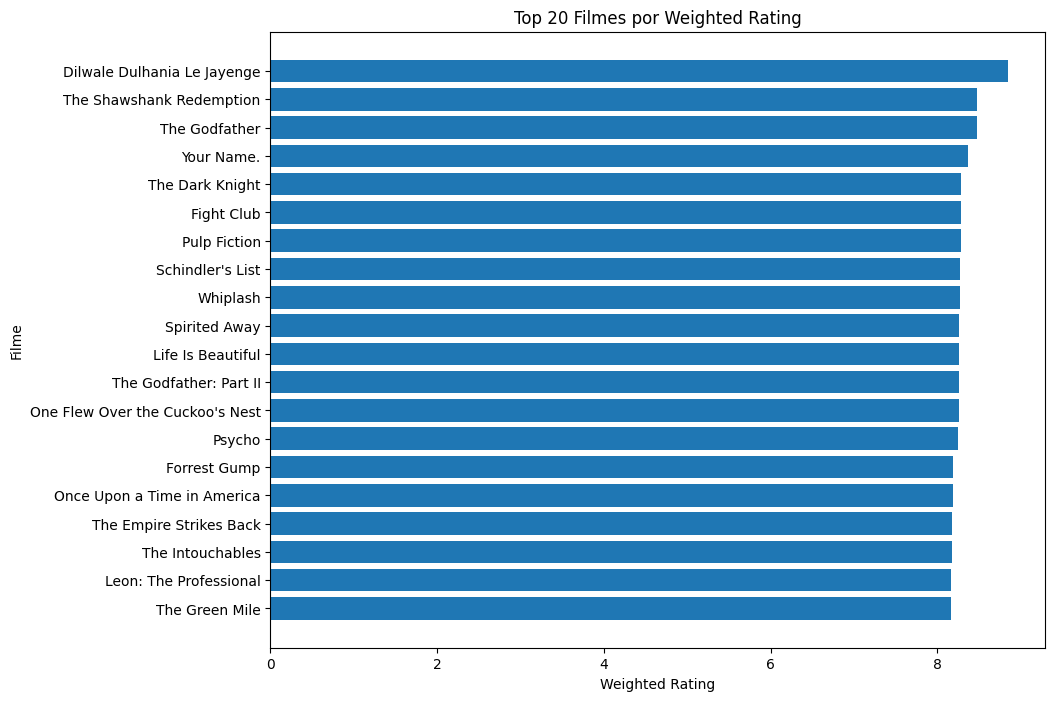

In [25]:
plot_top20_movies()

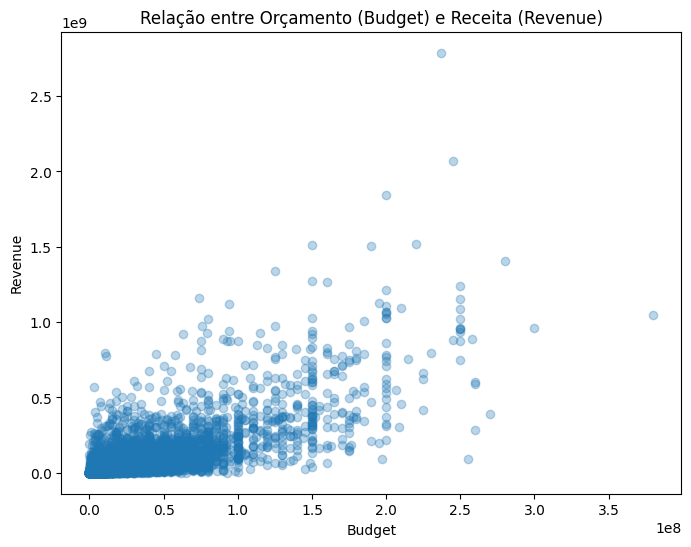

In [26]:
plot_budget_revenue_relation()

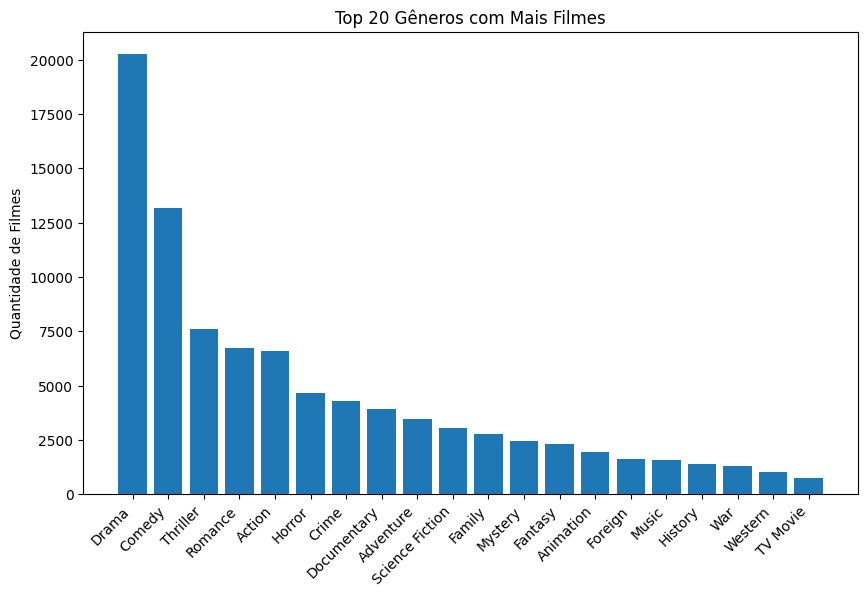

In [27]:
plot_popular_genres()

In [28]:
test_recommendation_example()


=== Teste de Recomendação ===
Usuário de teste: 49811
Gênero favorito do usuário 49811: Mystery

Top 10 recomendações:
                     title  weighted_rating
38             Rear Window         8.118353
511              Inception         8.091215
1                    Se7en         8.079198
193                Memento         8.070582
396           The Prestige         7.973885
345                 Oldboy         7.941910
43            Citizen Kane         7.907973
37                 Vertigo         7.901746
622              Gone Girl         7.881215
44   2001: A Space Odyssey         7.863493


Gênero favorito do usuário 400: War


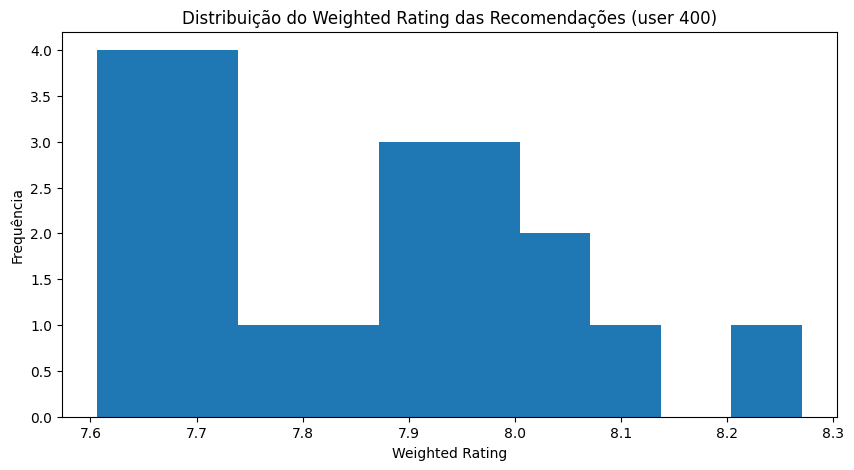

In [32]:
plot_recommendation_score_distribution(user_id=400)

In [ ]:
compare_user_vs_public(user_id=10, max_filmes=20)